In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(45)

In [62]:
df = pd.read_csv('ab_data.csv')

In [63]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [64]:
df.shape

(294480, 5)

In [65]:
df.describe()

,user_id,converted
count,294480.000000,294480.000000
mean,787973.538896,0.119658
std,91210.917091,0.324562
min,630000.000000,0.000000
25%,709031.750000,0.000000
50%,787932.500000,0.000000
75%,866911.250000,0.000000
max,945999.000000,1.000000


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [67]:
# number of unique user in the dataset
df.user_id.nunique()

290585

In [68]:
# Proportion of users converted
df.query('converted == 1').user_id.nunique()/df.user_id.nunique()

0.12104203589311217

In [69]:
# Number of times the new_page in the landing_page and the treatment in the group do not line 
df[((df['group'] == 'treatment')== (df['landing_page'] == 'new_page'))== False].shape[0]

3893

In [70]:
# The number of rows with missing values
df.isna().sum(axis = 1).sum()

0

## Data Cleaning 

1. Incorrect assignment of **group** and **landing_page**
- The 3893 rows which shows incorrect assingment were removed from the dataset **df** because the incorrect assignment renders these records inapproriate for analyzing the A/B test results.
- The updated dataset was assigned to a new object **df2**
- The new dataframe object **df2** does not contain any rows with incorrectly assigned **group** and **landing_page.**


In [71]:
# Updated dataframe with correct assigned group and landing_page
df2 = df.drop(df[((df['group'] == 'treatment') ==(df['landing_page'] == 'new_page'))== False].index)
df2.shape

(290587, 5)

In [72]:
# Valid the removal of rows with inaccurate assignment of group and landing_page
df2[((df2['group']== 'treatment') == (df2['landing_page'] == 'new_page'))== False].shape[0]

0

### Duplicate value in **user_id** column in the new dataframe object **df2**

In [73]:
# number of unique users in the update dataframe
df2.user_id.nunique()

290585

In [74]:
# duplicate user_id
user = {}
for userid in df.user_id:
    if userid not in user:
        user[userid] = 1
    else:
        user[userid] += 1
        duplicate_user_id = userid
        print(duplicate_user_id)

698120
773192
899953
790934
633793
839784
926754
793494
892450
883654
781656
790456
886965
870096
745943
700810
664347
779408
807355
667654
766921
635809
848099
634971
788011
646066
920614
666555
894409
664025
648778
645550
645517
704650
880498
674030
757854
931928
803248
702582
843786
853243
907972
783362
804758
669876
847508
809229
664919
673993
640111
807520
825223
647733
762688
938083
844346
672977
723181
726854
813523
823045
783176
792890
670282
928264
689745
730053
650842
879317
671530
695306
683936
716553
841210
732137
763291
794620
732074
870318
936606
778460
868922
634611
792850
894289
866677
759233
847153
856078
903687
886109
875990
676778
876593
835219
879725
696263
748761
751025
698216
697949
927663
895046
779142
863774
857084
757556
746137
756833
909376
647686
782432
826848
822805
831632
913995
831390
878562
652728
796192
631470
717343
746448
842042
913631
702878
883828
826566
749577
722256
727824
744956
894656
687916
873952
847673
633344
815115
663648
684279
666623
803613

In [75]:
# rows containing duplicate user_id
df2.query('user_id == @duplicate_user_id')

,user_id,timestamp,group,landing_page,converted
250001,759899,07:36.1,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0


In [76]:
# remove duplicate from df2
ind = df2.query('user_id == @duplicate_user_id').index[1]
df2.drop(labels = ind, inplace = True)
df2.reset_index(inplace = True, drop = True)

In [77]:
df2.shape

(290586, 5)

### Explatory Data Analysis

In [78]:
# Probability of a user converting regardless of the user's group
(df2['converted'] == 1).mean()

0.11959626410081697

In [79]:
# Probability of a user in the control group converting 
obs_p_old = (df2.query('group == "control"')['converted'] == 1).mean()
obs_p_old

0.1203863045004612

In [80]:
# Probability of a user in the treatment group converting
obs_p_new = (df2.query('group =="treatment"')['converted'] == 1).mean()
obs_p_new

0.11880643030169566

In [81]:
# Probability of a user receiving a new page
(df2['landing_page'] == 'new_page').mean()

0.5000653851183471

## A/B Test

In [82]:
# Convert rates for each group under the null
null_p_new = (df2['converted'] == 1).mean() #control
null_o_old = null_p_new #treatment
null_p_new

0.11959626410081697

In [83]:
# Sample size of the new page
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145312

In [84]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

In [85]:
# simulation of n_new outcomes with a convert rate of null_p_new
new_page_converted = np.random.binomial(n = 1, p = null_p_new, size = n_new)


In [86]:
# simulation of n_old outcomes with a convert rate of null_p_old
old_page_converted = np.random.binomial(n = 1, p = null_p_old, size = n_old)


In [87]:
#  Simulation of different in covert rates between groups
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

-0.0011116797875467543

In [88]:
# sampling distribution of 10000 differences in convert rates between groups
p_diffs = []

new_converted_sim = np.random.binomial(n = n_new, p = null_p_new, size = 10000)/n_new
old_converted_sim = np.random.binomial(n = n_old, p = null_p_old, size = 10000)/n_old
p_diffs.append(new_converted_sim - old_converted_sim) # 1000 differences

In [89]:
# mean and standard deviation of the sampling distribution
p_diffs_mean = np.array(p_diffs).mean()
p_diffs_std = np.array(p_diffs).std()
p_diffs_mean, p_diffs_std

(1.5143295013208476e-06, 0.0011972999418160524)

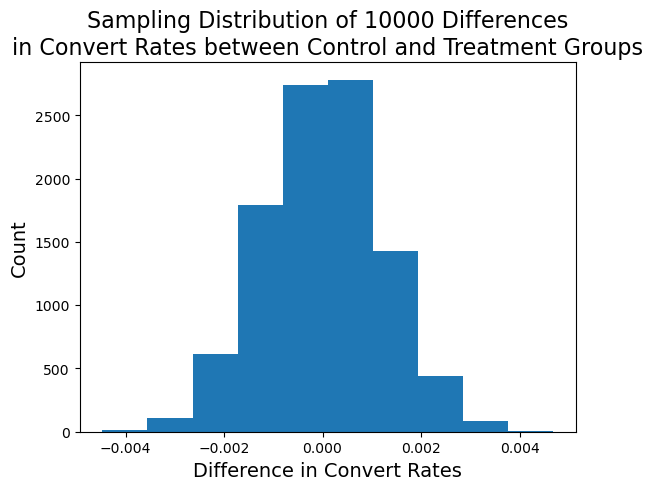

In [90]:
# histogram of 10000 differences in convert rates between groups
plt.hist(x = p_diffs)
plt.title('Sampling Distribution of 10000 Differences\nin Convert Rates between Control and Treatment Groups', fontsize = 16)
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Difference in Convert Rates', fontsize = 14);

In [91]:
# observed different in convert rates between groups
obs_p_diff = obs_p_new - obs_p_old
obs_p_diff

-0.0015798741987655407

In [93]:
# p-value: proportion of sampled differences larger than the observed different
p_val = (p_diffs > obs_p_diff).mean()
p_val

0.9065

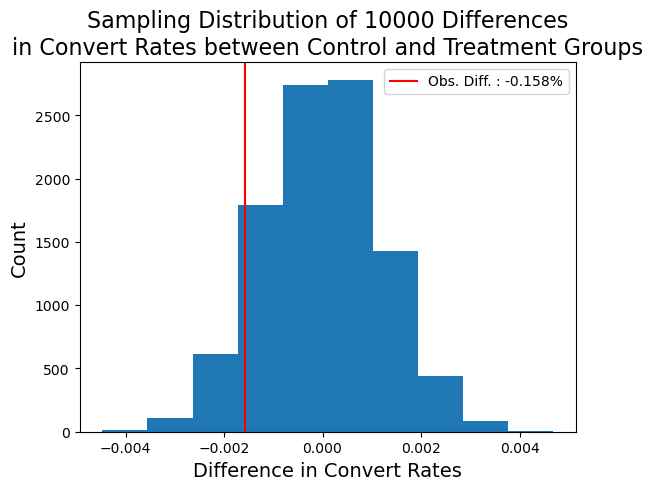

In [94]:
# Histogram of10000 different in convert rates between groups
plt.hist(x = p_diffs)
plt.axvline(x = obs_p_diff, color = 'r', label = 'Obs. Diff. : {}%'.format(round(obs_p_diff*100, 3)))
plt.title('Sampling Distribution of 10000 Differences\nin Convert Rates between Control and Treatment Groups', fontsize = 16)
plt.ylabel('Count', fontsize = 14)
plt.xlabel('Difference in Convert Rates', fontsize = 14)
plt.legend()

### Two Sample Z-test


In [108]:
from statsmodels.stats import proportion

# number of conversions for each page
convert_old = (df2.query('landing_page == "old_page"')['converted'] == 1).sum()
convert_new = (df2.query('landing_page == "new_page"')['converted'] == 1).sum()

In [110]:
zscore, pval = proportion.proportions_ztest(count = [convert_new, convert_old] # number of conversions
                                            , nobs = [n_new, n_old] # number of users in each page
                                            , alternative = 'larger')
zscore, pval

(-1.312290864396788, 0.9052889933017225)

In [111]:
# z-score and p-value from sampling distribution
z_score = (obs_p_diff - p_diffs_mean) / p_diffs_std
z_score, p_val

(-1.3207956277590955, 0.9065)